In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

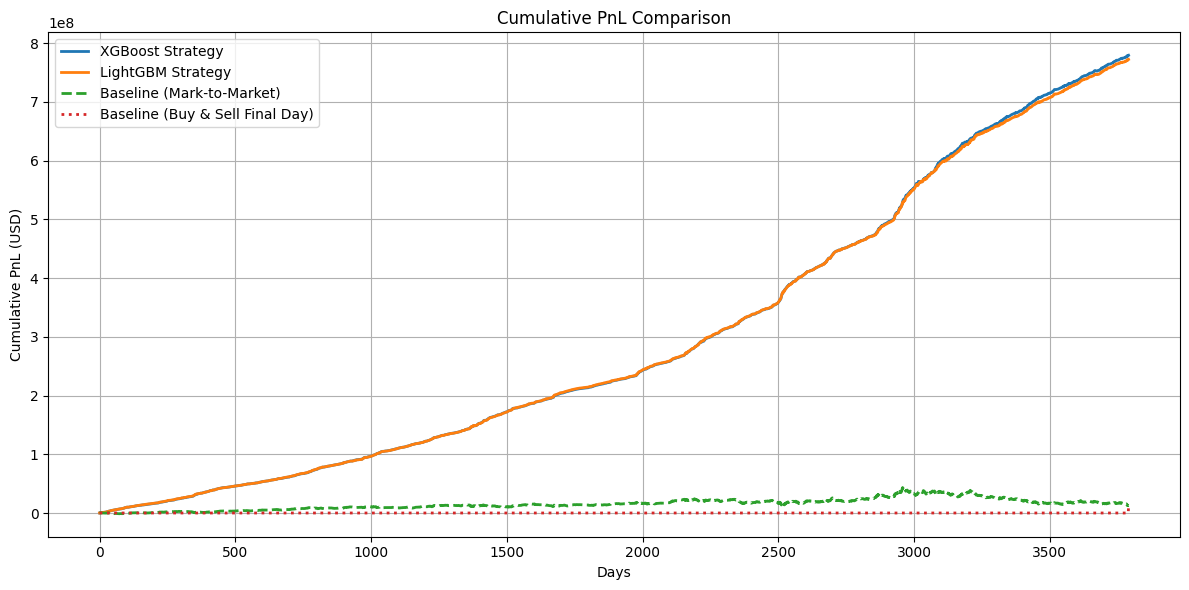

Final PnLs (USD):
XGBoost Strategy:           779,297,846.79
LightGBM Strategy:          772,301,487.92
Baseline (Buy+Sell Final):  12,973,632.81
Baseline (Mark-to-Market):  12,973,632.81


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


train_df = pd.read_csv("/Users/aashnaased/Desktop/TrexQuant_ML_Task/final_train_normalized.csv")
test_df = pd.read_csv("/Users/aashnaased/Desktop/TrexQuant_ML_Task/final_test_normalized.csv")
df = pd.read_csv("/Users/aashnaased/Desktop/TrexQuant_ML_Task/pfe_with_macro.csv")  

full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df.sort_values('Date', inplace=True)
full_df.reset_index(drop=True, inplace=True)

full_df['target'] = (full_df['target_return'] > 0).astype(int)
full_df['target_return_lag1'] = full_df['target_return'].shift(1)
X = full_df.drop(columns=["Date", "patent_expiry", "target_return", "target","target_return_lag1"])

closing_prices = df["Close_PFE"].reset_index(drop=True)

X = X.iloc[:-1]
price_today = closing_prices.iloc[:-1].values
price_tomorrow = closing_prices.iloc[1:].values
price_diff = price_tomorrow - price_today

model_xgb = joblib.load("best_model_xgb.pkl")
model_lgb = joblib.load("best_model_lgbm.pkl")

xgb_preds = model_xgb.predict(X)
lgb_preds = model_lgb.predict(X)

xgb_signals = np.where(xgb_preds > 0, 1, -1)
lgb_signals = np.where(lgb_preds > 0, 1, -1)

xgb_pnl = price_diff * xgb_signals * 1_000_000
lgb_pnl = price_diff * lgb_signals * 1_000_000
xgb_cum_pnl = np.cumsum(xgb_pnl)
lgb_cum_pnl = np.cumsum(lgb_pnl)

initial_price = closing_prices.iloc[0]
final_price = closing_prices.iloc[-1]
buy_hold_pnl = (final_price - initial_price) * 1_000_000
buy_hold_cum_pnl = np.zeros_like(xgb_cum_pnl)
buy_hold_cum_pnl[-1] = buy_hold_pnl 

mark_to_market_pnl = (closing_prices.iloc[1:].values - initial_price) * 1_000_000

plt.figure(figsize=(12, 6))
plt.plot(xgb_cum_pnl, label="XGBoost Strategy", linewidth=2)
plt.plot(lgb_cum_pnl, label="LightGBM Strategy", linewidth=2)
plt.plot(mark_to_market_pnl, label="Baseline (Mark-to-Market)", linestyle="--", linewidth=2)
plt.plot(buy_hold_cum_pnl, label="Baseline (Buy & Sell Final Day)", linestyle=":", linewidth=2)
plt.title("Cumulative PnL Comparison")
plt.xlabel("Days")
plt.ylabel("Cumulative PnL (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Final PnLs (USD):")
print(f"XGBoost Strategy:           {xgb_cum_pnl[-1]:,.2f}")
print(f"LightGBM Strategy:          {lgb_cum_pnl[-1]:,.2f}")
print(f"Baseline (Buy+Sell Final):  {buy_hold_pnl:,.2f}")
print(f"Baseline (Mark-to-Market):  {mark_to_market_pnl[-1]:,.2f}")
